# Deep Kernel Learning

## Theoretic Foundation

$\renewcommand{\bm}[1]{{\boldsymbol{\mathbf{#1}}}}$

Consider the kernel $k(\bm{x}_i,\bm{x}_j | \bm{\theta})$ with hyperparameters
$\bm{\theta}$, we transform the inputs (predictors) $\bm{x}$ as
\begin{align}
k(\bm{x}_i,\bm{x}_j | \bm{\theta}) \to k( g(\bm{x}_i, \bm{w}), g(\bm{x}_j, \bm{w}) | \bm{\theta},\bm{w}) \
\end{align}
where $g(\bm{x},\bm{w})$ is a non-linear mapping given by a deep architecture, such as a deep
convolutional network, parametrized by weights $\bm{w}$.\newline

For added flexibility, we also propose to use **spectral mixture** base kernels:

\begin{align}
k_{\text{SM}}(\bm{x},\bm{x}' | \bm{\theta}) =   
\sum_{q=1}^Q a_q \frac{|\Sigma_q|^{\frac{1}{2}}}{(2\pi)^{\frac{D}{2}}}
\exp \left(-\frac{1}{2} || \Sigma_q ^{\frac{1}{2}} (\bm{x}-\bm{x}') ||^2 \right )
\cos \langle \bm{x}-\bm{x}', 2\pi \bm{\mu}_q \rangle \
\end{align}

The parameters of the spectral mixture kernel $\bm{\theta} = \{{a}_q, \Sigma_q, \bm{\mu}_q\}$
are mixture weights, bandwidths (inverse length-scales), and frequencies.
The spectral mixture (SM) kernel, which forms an expressive basis for all stationary covariance functions, can
discover quasi-periodic stationary structure with an interpretable and succinct representation,
while the deep learning transformation $g(\bm{x},\bm{w})$ captures non-stationary and hierarchical
structure.

We use the deep kernel of equation as the covariance function of a Gaussian process to model data $\mathcal{D} = \{\bm{x}_i, \bm{y}_i\}_{i=1}^{n}$.

### Combining GPs and DNNs in a scalable way

Conditioned on kernel hyperparameters, we can interpret the model:
- a Gaussian process with base kernel $k_\bm{\theta}$
- the GP is applied to the last layer of a DNN, i.e. the data $X$ in  equation is replaced by data transformed through a DNN $X \rightarrow g(X, \bm{w})$ where the network $g$ is applied point-wise


We emphasize, however, that we **jointly** learn all deep kernel hyperparameters,
$\bm{\gamma} = \{ \bm{w},\bm{\theta} \}$,
which include $\bm{w}$, the weights of the
network, and $\bm{\theta}$ the parameters of the base kernel, by maximizing the
log **marginal likelihood** ~$\mathcal{L}$ of the Gaussian process (see
Eq.~\eqref{eqn: mlikeliDNN}). 

\begin{equation}
 \log p(\bm{y} | \bm{\gamma}, X, \bm{w}) \propto -[\bm{y}^{\top}(K_{\bm{\gamma}, \bm{w}}+\sigma^2 I)^{-1}\bm{y} + \log|K_{\bm{\gamma}, \bm{w}} + \sigma^2 I|]\
\end{equation}

Except for the replacement of input data, now one can almost follow the same procedures for learning
and inference as for GPs.


Now for optimizing \eqref{eqn: mlikeliDNN}, we use the chain rule to compute derivatives of the log
marginal likelihood with respect to the deep kernel hyperparameters:

\begin{align}
    \frac{\partial \mathcal{L}}{\partial \bm{\theta}} = \frac{\partial \mathcal{L}}{\partial K_{\bm{\gamma}}} \frac{\partial K_{\bm{\gamma}}}{\partial \bm{\theta}}\,,
    \quad \frac{\partial \mathcal{L}}{\partial \bm{w}} = \frac{\partial \mathcal{L}}{\partial K_{\bm{\gamma}}} \frac{ \partial K_{\bm{\gamma}}}{\partial g(\bm{x},\bm{w})}
    \frac{\partial g(\bm{x},\bm{w})}{\partial \bm{w}}
\end{align}

The implicit derivative of the log marginal likelihood
with respect to our $n \times n$ data covariance matrix $K_{\bm{\gamma}}$
is given by

\begin{align}
    \frac{\partial \mathcal{L}}{\partial K_{\bm{\gamma}}} = \frac{1}{2} (K_{\bm{\gamma}}^{-1} \bm{y}\bm{y}^{\top} K_{\bm{\gamma}}^{-1}
    - K_{\bm{\gamma}}^{-1}) \,,
\end{align}

where we have absorbed the noise covariance $\sigma^2 I$ into our covariance
matrix, and treat it as part of the base kernel hyperparameters $\bm{\theta}$.
$\frac{\partial K_{\bm{\gamma}}}{\partial \bm{\theta}}$ are the derivatives of
the deep kernel with respect to the base kernel hyperparameters (such as length-scale),
conditioned on the fixed transformation of the inputs $g(\bm{x},\bm{w})$.  Similarly,
$\frac{ \partial K_{\bm{\gamma}}}{\partial g(\bm{x},\bm{w})}$ are the implicit derivatives
of the deep kernel with respect to $g$, holding $\bm{\theta}$ fixed.  The derivatives
with respect to the weight variables $\frac{\partial g(\bm{x},\bm{w})}{\partial \bm{w}}$ are
computed using standard backpropagation. \newline

For scalability, we replace all instances of $K_{\bm{\gamma}}$ with the KISS-GP
covariance matrix 

\begin{align}
K_{\bm{\gamma}} \approx M K^{\text{deep}}_{U,U} M^{\top} := K_{\text{KISS}} \,,
\end{align}

where $M$ is a sparse matrix of interpolation weights, containing only
$4$ non-zero entries per row for local cubic interpolation, and $K_{U,U}$
is a covariance matrix created from our deep kernel, evaluated over $M$ latent inducing
points $U = [\mathbf{u}_i]_{i=1 \dots M}$.

We place the inducing points over a regular multidimensional lattice, and
exploit the resulting decomposition of $K_{U,U}$ into a Kronecker product of
Toeplitz matrices for extremely fast matrix vector multiplications (MVMs), without requiring
any grid structure in the data inputs~$X$ or the transformed inputs $g(\bm{x},\bm{w})$.

## Imports

In [1]:
import os
import sys

# required to make the path visible to import the tools
# this will change in public notebooks to be "pip install uq-regression-box"
nb_dir = os.path.split(os.path.split(os.getcwd())[0])[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
nb_dir

import tempfile
from functools import partial

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from gpytorch.mlls import VariationalELBO
from lightning import Trainer
from lightning.pytorch import seed_everything
from lightning.pytorch.loggers import CSVLogger

from lightning_uq_box.datamodules import ToyHeteroscedasticDatamodule
from lightning_uq_box.models import MLP
from lightning_uq_box.uq_methods import DeepKernelLearningModel, DKLGPLayer
from lightning_uq_box.viz_utils import (
    plot_calibration_uq_toolbox,
    plot_predictions,
    plot_toy_data,
    plot_training_metrics,
)

plt.rcParams["figure.figsize"] = [14, 5]

In [2]:
seed_everything(0)  # seed everything for reproducibility

Global seed set to 0


0

We define a temporary directory to look at some training metrics and results.

In [3]:
my_temp_dir = tempfile.mkdtemp()

## Datamodule

To demonstrate the method, we will make use of a Toy Regression Example that is defined as a [Lightning Datamodule](https://lightning.ai/docs/pytorch/stable/data/datamodule.html). While this might seem like overkill for a small toy problem, we think it is more helpful how the individual pieces of the library fit together so you can train models on more complex tasks.

In [4]:
dm = ToyHeteroscedasticDatamodule()

X_train, y_train, train_loader, X_test, y_test, test_loader = (
    dm.X_train,
    dm.y_train,
    dm.train_dataloader(),
    dm.X_test,
    dm.y_test,
    dm.test_dataloader(),
)

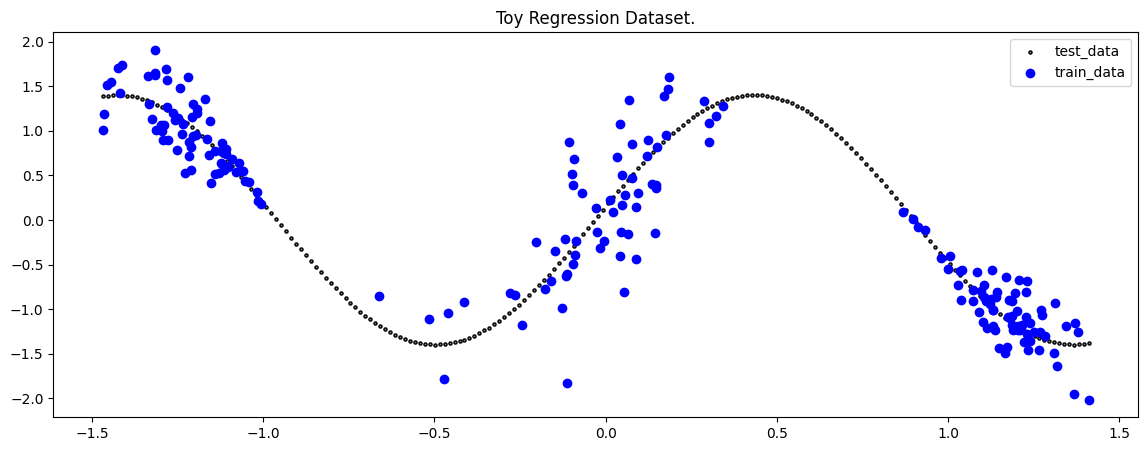

In [5]:
plot_toy_data(X_train, y_train, X_test, y_test)

## Model

For our Toy Regression problem, we will use a simple Multi-layer Perceptron (MLP) that you can configure to your needs. For the documentation of the MLP see [here](https://torchgeo.readthedocs.io/en/stable/api/models.html#MLP).

In [6]:
feature_extractor = MLP(
    n_inputs=1, n_outputs=10, n_hidden=[100], activation_fn=torch.nn.ReLU()
)
feature_extractor

MLP(
  (model): Sequential(
    (0): Linear(in_features=1, out_features=100, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.0, inplace=False)
    (3): Linear(in_features=100, out_features=10, bias=True)
  )
)

With an underlying neural network, we can now use our desired UQ-Method as a sort of wrapper. All UQ-Methods are implemented as [LightningModule](https://lightning.ai/docs/pytorch/stable/common/lightning_module.html) that allow us to concisely organize the code and remove as much boilerplate code as possible.

In [7]:
dkl_model = DeepKernelLearningModel(
    feature_extractor=feature_extractor,
    gp_layer=partial(DKLGPLayer, n_outputs=1, kernel="RBF"),
    elbo_fn=partial(VariationalELBO),
    optimizer=partial(torch.optim.Adam, lr=1e-3),
    train_loader=train_loader,
    n_inducing_points=50,
    save_dir=my_temp_dir,
)

## Trainer

Now that we have a LightningDataModule and a UQ-Method as a LightningModule, we can conduct training with a [Lightning Trainer](https://lightning.ai/docs/pytorch/stable/common/trainer.html). It has tons of options to make your life easier, so we encourage you to check the documentation.

In [8]:
logger = CSVLogger(my_temp_dir)
trainer = Trainer(
    max_epochs=500,  # number of epochs we want to train
    logger=logger,  # log training metrics for later evaluation
    log_every_n_steps=1,
    enable_checkpointing=False,
    enable_progress_bar=False,
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training our model is now easy:

In [14]:
trainer.fit(dkl_model, dm)


  | Name              | Type               | Params
---------------------------------------------------------
0 | feature_extractor | MLP                | 1.2 K 
1 | train_metrics     | MetricCollection   | 0     
2 | val_metrics       | MetricCollection   | 0     
3 | test_metrics      | MetricCollection   | 0     
4 | gp_layer          | DKLGPLayer         | 3.1 K 
5 | scale_to_bounds   | ScaleToBounds      | 0     
6 | likelihood        | GaussianLikelihood | 1     
7 | elbo_fn           | VariationalELBO    | 3.1 K 
---------------------------------------------------------
4.3 K     Trainable params
0         Non-trainable params
4.3 K     Total params
0.017     Total estimated model params size (MB)
/home/nils/.virtualenvs/uqboxEnv/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argume

## Training Metrics

To get some insights into how the training went, we can use the utility function to plot the training loss and RMSE metric.

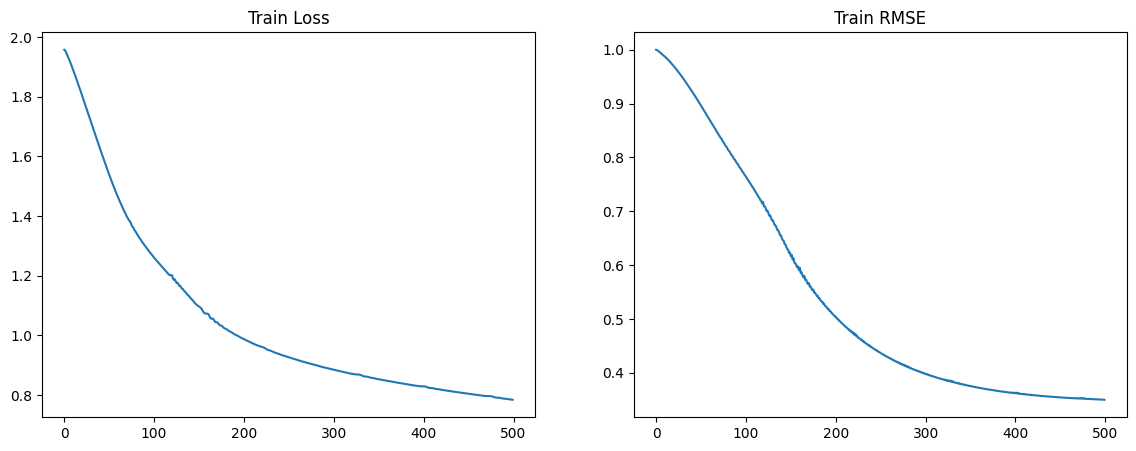

In [16]:
fig = plot_training_metrics(my_temp_dir)

## Prediction

In [17]:
preds = dkl_model.predict_step(X_test)

## Evaluate Predictions

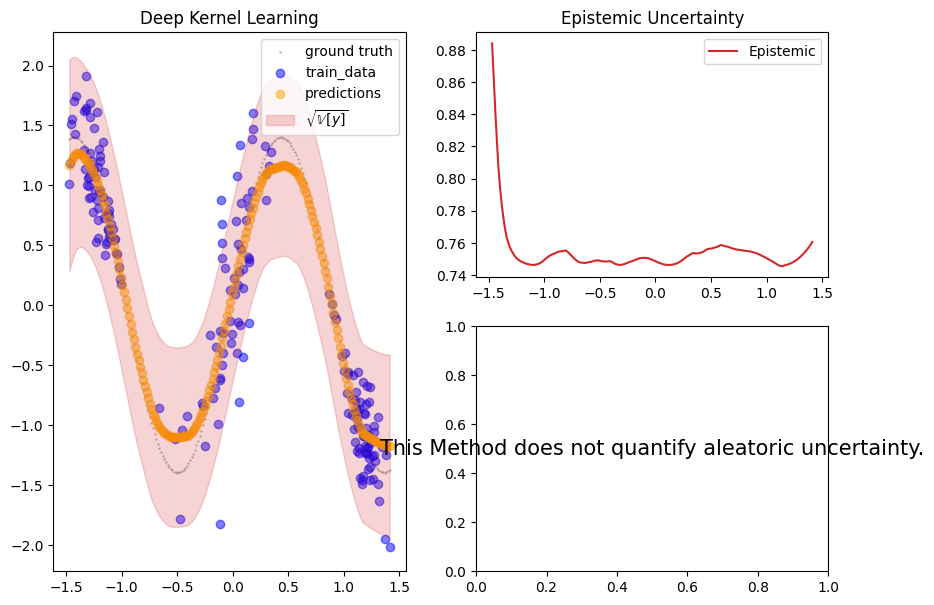

In [20]:
fig = plot_predictions(
    X_train,
    y_train,
    X_test,
    y_test,
    preds["mean"],
    preds["pred_uct"],
    epistemic=preds["epistemic_uct"],
    title="Deep Kernel Learning",
    show_bands=False,
)

For some additional metrics relevant to UQ, we can use the great [uncertainty-toolbox](https://uncertainty-toolbox.github.io/) that gives us some insight into the calibration of our prediction. For a discussion of why this is important, see ...

<Figure size 1400x500 with 0 Axes>

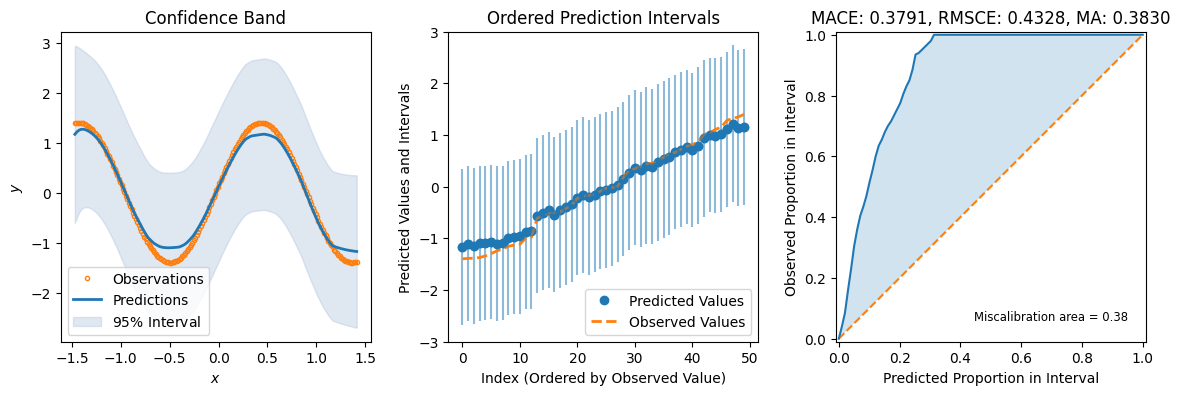

In [21]:
fig = plot_calibration_uq_toolbox(
    preds["mean"], preds["pred_uct"], y_test.cpu().numpy(), X_test.cpu().numpy()
)

## Additional Resources

Links to othere related literature that might be interesting.